# 集成学习 - XGBoost（B站公开课课件）

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import re, pip, conda
import time
import os

In [2]:
for package in [sklearn,mlp,np,pd,sns,pip,conda]:
    print(re.findall("([^']*)",str(package))[2],package.__version__)

sklearn 1.0.1
matplotlib 3.4.3
numpy 1.21.4
pandas 1.3.4
seaborn 0.11.2
pip 21.3.1
conda 4.11.0


In [3]:
#更新pip
#pip install --upgrade pip

#使用pip/conda更新sklearn
#pip install --upgrade scikit-learn
#conda update scikit-learn

目录

<font color=green>**【公开课】**</font>**一 XGBoost的基本思想与实现**<br>
<font color=green>**【公开课】**</font>&emsp;1 XGBoost pk 梯度提升树<br>
<font color=green>**【公开课】**</font>&emsp;2 XGBoost的sklearnAPI实现<br>
<font color=green>**【公开课】**</font>&emsp;3 XGBoost的原生库代码实现<br>
<font color=red>**【完整版】**</font>&emsp;4 XGBoost分类器的实现<br>
<font color=red>**【完整版】**</font>**二 XGBoost的参数**<br>
<font color=red>**【完整版】**</font>&emsp;1 迭代过程<br>
<font color=red>**【完整版】**</font>&emsp;&emsp; 1.1 迭代次数/学习率/初始$H_0$/最大迭代值<br>
<font color=green>**【公开课】**</font>&emsp;&emsp; 1.2 XGBoost的目标函数<br>
<font color=red>**【完整版】**</font>&emsp;2 XGBoost中的弱评估器<br>
<font color=red>**【完整版】**</font>&emsp;&emsp; 2.1 三大评估器与DART树<br>
<font color=green>**【公开课】**</font>&emsp;&emsp; 2.2 XGBoost中弱评估器的分枝<br>
<font color=red>**【完整版】**</font>&emsp;&emsp; 2.3 控制复杂度（一）：弱评估器的剪枝<br>
<font color=red>**【完整版】**</font>&emsp;&emsp; 2.4 控制复杂度（一）：弱评估器的训练数据<br>
<font color=red>**【完整版】**</font>&emsp;3 XGBoost的其他参数与方法<br>
<font color=red>**【完整版】**</font>**三 XGBoost中参数空间与自动优化**<br>
<font color=red>**【完整版】**</font>&emsp;1 XGBoost的参数空间<br>
<font color=red>**【完整版】**</font>&emsp;2 基于TPE对XGBoost进行优化<br>
<font color=red>**【完整版】**</font>**四 原理进阶：XGBoost的求解流程**<br>
<font color=red>**【完整版】**</font>&emsp;1 XGBoost的基本数学流程<br>
<font color=red>**【完整版】**</font>&emsp;2 化简XGBoost的目标函数<br>
<font color=red>**【完整版】**</font>&emsp;3 令XGBoost的目标函数最小<br>

推荐的学习路径：

【快速实现XGBoost、跑通代码】- 第一部分<br>
【快速掌握XGBoost应用、达到自由调参水平】- 第一部分~第三部分<br>
【快速掌握XGBoost原理、面试得以通关】- 第一部分1 + 第二部分1.2、2.2 + 第四部分<br>

# 一 XGBoost的基础思想与实现

## 1 XGBoost pk 梯度提升树

极限提升树XGBoost(Extreme Gradient Boosting，XGB，发音/æks-g-boost/)是基于梯度提升树GBDT全面升级的新一代提升算法，也是提升家族中最富盛名、最灵活、最被机器学习竞赛所青睐的算法。不同于我们之前学过的任意单一算法，XGBoost是一个以提升树为核心的算法系统，它覆盖了至少3+建树流程、10+损失函数，可以实现各种类型的梯度提升树，灵活性无与伦比。同时，XGBoost天生被设计成支持巨量数据，因此可以自由接入GPU/分布式/数据库等系统、还创新了众多工程上对传统提升算法进行加速的新方法。可以说，XGBoost是21世纪中Boosting算法的又一个里程碑，它开创了后GBDT时代中Boosting算法的新辉煌。

**<font color="red">需要注意的是，学习XGBoost需要大量梯度提升树（GBDT）相关知识，本课程将假设你已经非常熟悉梯度提升树的原理与特点、并且熟悉sklearn中的交叉验证的用法。如果你不熟悉梯度提升树，强烈建议你回顾之前的课程。</font>**

作为Boosting算法，XGBoost中自然包含Boosting三要素：

- 损失函数$L(y,\hat{y})$ ：用以衡量模型预测结果与真实结果的差异。<br>
- 弱评估器$f(x)$ ：（一般为）决策树，不同的boosting算法使用不同的建树过程。<br>
- 综合集成结果$H(x)$：即集成算法具体如何输出集成结果

并且，XGBoost也遵循Boosting算法的基本流程进行建模：

---
**<font color="green"><center>依据上一个弱评估器$f(x)_{k-1}$的结果，计算损失函数$L$，
    <br>并使用$L$自适应地影响下一个弱评估器$f(x)_k$的构建。<br>集成模型输出的结果，受到整体所有弱评估器$f(x)_0$ ~ $f(x)_K$的影响。</center></font>**
---

当然，XGBoost真实的流程比上述过程复杂得多。虽然梯度提升树的流程本身已经比较复杂，XGBoost还是在此流程上做出了众多关键的改进。综合来看，这些改进都是基于XGBoost中两种非常关键的思想实现的：

- **第一，实现精确性与复杂度之间的平衡**<br>

树的集成模型是机器学习中最为强大的学习器之一，这一族学习器的特点是精确性好、适用于各种场景，但运行缓慢、且过拟合风险很高，因此从学习单一决策树时起，我们就持续为大家提供丰富的剪枝策略，目的就是为了降低各种树模型的模型复杂度，从而控制住过拟合。**树模型的学习能力与过拟合风险之间的平衡，就是预测精确性与模型复杂度之间的平衡，也是经验风险与结构风险之间的平衡**，这一平衡对决策树以及树的集成模型来说是永恒的议题。<br>

在过去，我们总是先建立效果优异的模型，再依赖于手动剪枝来调节树模型的复杂度，但在XGBoost中，精确性与复杂度会在训练的每一步被考虑到。主要体现在：

> - **1. XGBoost为损失函数$L(y,\hat{y})$加入结构风险项，构成目标函数$O(y,\hat{y})$**<br><br>
> 在AdaBoost与GBDT当中，我们的目标是找到损失函数$L(y,\hat{y})$的最小值，也就是让预测结果与真实结果差异最小，这一流程只关心精确性、不关心复杂度和过拟合情况。为应对这个问题，XGBoost从决策树的预剪枝流程、逻辑回归、岭回归、Lasso等经典算法的抗过拟合流程吸取经验，在损失函数中加入了控制过拟合的结构风险项，并将【$L(y,\hat{y})$ + 结构风险】定义为目标函数$O(y,\hat{y})$。<br><br>
> 这一变化让XGBoost在许多方面都与其他Boosting算法不同：例如，XGBoost是向着令目标函数最小化的目标进行训练，而不是令损失函数最小化的方向。再比如，XGBoost会优先利用结构风险中的参数来控制过拟合，而不像其他树的集成模型一样依赖于树结构参数（例如`max_depth`，`min_impurity_decrease`等）。<br><br>
> - **2. 使用全新不纯度衡量指标，将复杂度纳入分枝规则**<br><br>
> 在之前学过的算法当中，无论Boosting流程如何进化，建立单棵决策树的规则基本都遵循我们曾经学过的CART树流程，在分类树中，我们使用信息增益（information gain）来衡量叶子的质量，在回归树中，我们使用MSE或者弗里德曼MSE来衡量叶子的质量。这一流程有成熟的剪枝机制、预测精度高、能够适应各种场景，但却可能建立复杂度很高的树。<br><br>
> 为实现精确性与复杂度之间的平衡，XGBoost重新设定了分枝指标**【结构分数】**（原论文中写作Structure Score，也被称为质量分数Quality Score），以及基于结构分数的**【结构分数增益】**（Gain of structure score），结构分数增益可以逼迫决策树向整体结构更简单的方向生长。<br><br>
> 这一变化让XGBoost使用与传统CART略有区别的建树流程，同时在建树过程中大量使用残差（Residuals）或类残差对象作为中间变量，因此XGBoost的数学过程比其他Boosting算法更复杂。

- **第二，极大程度地降低模型复杂度、提升模型运行效率，将算法武装成更加适合于大数据的算法**<br>

在任意决策树的建树过程中，都需要对每一个特征上所有潜在的分枝节点进行不纯度计算，当数据量巨大时，这一计算将消耗巨量的时间，因此树集成模型的关键缺点之一就是计算缓慢，而这一缺点在实际工业环境当中是相当致命的。为了提升树模型的运算速度、同时又不极大地伤害模型的精确性，XGBoost使用多种优化技巧来实现效率提升：<br>

> - **1. 使用估计贪婪算法、平行学习、分位数草图算法等方法构建了适用于大数据的全新建树流程**<br><br>
> - **2. 使用感知缓存访问技术与核外计算技术，提升算法在硬件上的运算性能**<br><br>
> - **3. 引入Dropout技术，为整体建树流程增加更多随机性、让算法适应更大数据**<br><br>
> 不仅在数学方法上有所改进，XGBoost正式拉开了Boosting算法工程优化的序幕。后续更多的Boosting算法，包括LightGBM，CatBoost等也都是在工程方法上做出了大量的优化。遗憾的是，XGBoost的平行学习、估计贪婪算法等知识点将不会被包括在本次课程当中。在讲解LightGBM的时候，我们将详解基于直方图的估计算法，那时我们就能够很容易地理解XGBoost所使用的估计贪婪算法了。

除此之外，XGBoost还保留了部分与梯度提升树类似的属性，包括：

- **弱评估器的输出类型与集成算法输出类型不一致**

> 对于AdaBoost或随机森林算法来说，当集成算法执行的是回归任务时，弱评估器也是回归器，当集成算法执行分类任务时，弱评估器也是分类器。但对于GBDT以及基于GBDT的复杂Boosting算法们而言，**无论集成算法整体在执行回归/分类/排序任务，弱评估器一定是回归器**。GBDT通过sigmoid或softmax函数输出具体的分类结果，但实际弱评估器一定是回归器，XGBoost也是如此。

- **拟合负梯度，且当损失函数是0.5倍MSE时，拟合残差**

> 任意Boosting算法都有自适应调整弱评估器的步骤。在GBDT当中，每次用于建立弱评估器的是样本$X$以及当下集成输出$H(x_i)$与真实标签$y$之间的伪残差（也就是负梯度）。当损失函数是$\frac{1}{2}MSE$时，负梯度在数学上等同于残差（Residual），因此**GBDT是通过拟合残差来影响后续弱评估器结构**。XGBoost也是依赖于拟合残差来影响后续弱评估器结构，但是与GBDT一样，这一点需要通过数学来证明。

- **抽样思想**

> GBDT借鉴了大量Bagging算法中的抽样思想，XGBoost也继承了这一属性，因此在XGBoost当中，我们也可以对样本和特征进行抽样来增大弱评估器之间的独立性

因为存在这些相似之处，因此我们将会在XGBoost的参数中看到部分熟悉的参数，如果你对梯度提升树足够熟悉，那XGBoost的许多参数对你来说应该并不难懂。需要注意的是，作为2014年才被正式提出的Boosting算法，XGBoost是一个独立于经典算法的算法系统，因此xgboost库是需要单独安装的。

你可以使用以下代码在cmd中非常简单地安装xgboost，通常来说无需配置环境变量。

In [4]:
#!pip install xgboost #安装xgboost库
#!pip install --upgrade xgboost #更新xgboost库

In [5]:
import xgboost as xgb #导入成功则说明安装正确

In [6]:
xgb.__version__

'1.5.1'

需要注意的是，windows与linux系统下支持单GPU运算，但Mac系统不支持GPU运算。同时，只有Linux系统支持多GPU联合运算，其他系统不支持。如果pip安装失败，则可以删除后参考该页面进行具体安装：https://xgboost.readthedocs.io/en/stable/install.html

## 2 XGBoost回归的sklearnAPI实现

不同于内嵌在sklearn框架中的其他算法，xgboost是独立的算法库，因此它有一套不同于sklearn代码的原生代码。大部分时候我们使用原生代码来运行xgboost，因为这套原生代码是完全为集成学习所设计的，不仅可以无缝使用交叉验证、默认输出指标为RMSE，还能够默认输出训练集上的结果帮我们监控模型。然而对于熟悉sklearn的我们来说，这一套代码略有难度，因此许多人也会倾向于使用xgboost自带的sklearn接口来实现算法。

XGBoost自带sklearn接口（sklearn API），通过这个接口，我们可以使用跟sklearn代码一样的方式来实现xgboost，即可以通过fit和predict等接口来执行训练预测过程，也可以调用属性比如coef_等。在XGBoost的sklearn API中，我们可以看到下面五个类：

|类|说明|
|:-:|:-:|
|**XGBRegressor()**|实现xgboost回归|
|**XGBClassifier()**|实现xgboost分类|
|**XGBRanker()**|实现xgboost排序|
|**XGBRFClassifier()**|基于xgboost库实现随机森林分类|
|**XGBRFRegressor()**|基于xgboost库实现随机森林回归|

其中XGBRF的两个类是以XGBoost方式建树、但以bagging方式构建森林的类，通常只有在我们使用普通随机森林效果不佳、但又不希望使用Boosting的时候使用。这种使用XGBoost方式建树的森林在sklearn中已经开始了实验，不过还没有正式上线。

另外两个类就很容易理解了，一个是XGBoost的回归，一个是XGBoost的分类。这两个类的参数高度相似，我们可以以XGBoost回归为例查看：

*class* `xgboost.XGBRegressor`(n_estimators, max_depth, learning_rate, verbosity, objective, booster, tree_method, n_jobs, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, reg_alpha, reg_lambda, scale_pos_weight, base_score, random_state, missing, num_parallel_tree, monotone_constraints, interaction_constraints, importance_type, gpu_id, validate_parameters, predictor, enable_categorical, eval_metric, early_stopping_rounds, callbacks,**kwargs)

*class* `xgboost.XGBClassifier`(n_estimators, use_label_encoder, max_depth, learning_rate, verbosity, objective, booster, tree_method, n_jobs, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, reg_alpha, reg_lambda, scale_pos_weight, base_score, random_state, missing, num_parallel_tree, monotone_constraints, interaction_constraints, importance_type, gpu_id, validate_parameters, predictor, enable_categorical, **kwargs)

可以看到，两个类的参数两都很多，其中不乏一些我们非常熟悉的参数，例如`n_estimators`，`learning_rate`, `max_depth`等。但大部分参数还是需要我们重新学习和认识，这与xgboost复杂的原理有很大的关系，但由于是sklearn API，所以所有这些参数都有相应的默认值。我们可以在不认识参数的情况下调用这个类。以回归类为例我们来看：

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import train_test_split

In [8]:
data = pd.read_csv(r"D:\Pythonwork\2021ML\PART 2 Ensembles\datasets\House Price\train_encode.csv",index_col=0)

In [9]:
data.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态,SalePrice
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0,208500
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0,181500
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0,223500
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,140000
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0,250000


In [10]:
#回归数据
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [11]:
X.shape

(1460, 80)

In [12]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

在这个数据集上我们曾经达到过如下的分数：

|算法|RF|AdaBoost|GBDT|RF<br>(TPE)|AdaBoost<br>(TPE)|GBDT<br>(TPE)|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|1.29s|0.28s|0.49s|0.22s|0.27s|<font color="brown">**1.54s(↑)**</font>|
|测试最优分数<br>(RMSE)|30571.267|35345.931|28783.954|28346.673|35169.730|<font color="green">**26415.835(↓)**</font>|

In [13]:
#sklearn普通训练代码三步走：实例化，fit，score

Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=1412)

xgb_sk = XGBRegressor(random_state=1412) #实例化模型
xgb_sk.fit(Xtrain,Ytrain)
xgb_sk.score(Xtest,Ytest) #默认指标R2

0.8707175563742298

In [20]:
#sklearn交叉验证三步走：实例化，交叉验证，对结果求平均

xgb_sk = XGBRegressor(random_state=1412) #实例化模型

In [31]:
#定义所需的交叉验证方式
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

result_xgb_sk = cross_validate(xgb_sk,X,y,cv=cv
                               ,scoring="neg_root_mean_squared_error" #负根均方误差
                               ,return_train_score=True
                               ,verbose=True
                               ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


In [32]:
result_xgb_sk

{'fit_time': array([0.23205304, 0.45810175, 0.46110272, 0.47810745, 0.47210622]),
 'score_time': array([0.00499988, 0.00500083, 0.00700212, 0.00600123, 0.0080018 ]),
 'test_score': array([-25398.06063039, -42892.11176772, -26426.91326917, -20676.41934632,
        -33375.56869975]),
 'train_score': array([ -903.74997856, -1106.45801425,  -997.3799282 ,  -818.69215194,
         -877.57892862])}

In [33]:
def RMSE(result,name):
    return abs(result[name].mean())

In [34]:
RMSE(result_xgb_sk,"train_score")

940.7718003131752

In [35]:
RMSE(result_xgb_sk,"test_score")

29753.814742669765

可以看到，在默认参数下，xgboost模型极度不稳定，并且过拟合的情况非常严重，在训练集上的RMSE达到了前所未有的低点940.77，这说明XGBoost的学习能力的确强劲，现有数据量对xgboost来说可能有点不足。在没有调整任何参数的情况下，XGBoost的表现没能胜过梯度提升树，这可能是因为在默认参数下梯度提升树的过拟合程度较轻。我们可以尝试使用之前学过的知识，对XGBoost的参数略微进行调整，例如将最可能影响模型的参数之一：`max_depth`设置为一个较小的值。

In [36]:
xgb_sk = XGBRegressor(max_depth=5,random_state=1412) #实例化

In [37]:
result_xgb_sk = cross_validate(xgb_sk,X,y,cv=cv
                               ,scoring="neg_root_mean_squared_error" #负根均方误差
                               ,return_train_score=True
                               ,verbose=True
                               ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [38]:
RMSE(result_xgb_sk,"train_score")

2362.6596931022264

In [39]:
RMSE(result_xgb_sk,"test_score")

28623.2199609373

过拟合程度立刻减轻了，这说明模型是有潜力的，经过精密的调参之后xgboost上应该能够获得不错的结果。

当sklearn API训练完毕之后，我们可以调用sklearn中常见的部分属性对训练后的模型进行查看，例如查看特征重要性的属性`feature_importances_`，以及查看XGB下每一棵树的`get_booster()`方法、查看总共有多少棵树的`get_num_boosting_rounds()`方法、以及查看当前所有参数的方法`get_params`。

In [46]:
xgb_sk = XGBRegressor(max_depth=5,random_state=1412).fit(X,y)

In [47]:
#查看特征重要性
xgb_sk.feature_importances_

array([2.75380560e-04, 3.31971998e-04, 1.00358156e-02, 1.05883693e-03,
       3.16664134e-03, 0.00000000e+00, 1.98506648e-04, 2.89293937e-03,
       1.25273280e-02, 0.00000000e+00, 5.93377743e-04, 1.02778999e-02,
       2.30982271e-03, 1.63636741e-03, 2.90878420e-03, 2.35304120e-03,
       6.21278654e-04, 4.83804524e-01, 3.57081974e-03, 5.26868505e-03,
       5.39273489e-03, 1.19193934e-03, 6.73988950e-04, 8.58596177e-04,
       7.24220707e-04, 6.31435658e-04, 6.40772341e-04, 1.79228242e-02,
       1.88877675e-04, 5.03550633e-04, 1.56989340e-02, 2.03612563e-03,
       2.47432292e-03, 1.01661379e-03, 8.10322072e-03, 2.90135911e-04,
       5.88890282e-04, 7.41500990e-04, 1.55724427e-02, 4.79830429e-04,
       3.00964224e-04, 3.08048874e-02, 1.71841952e-04, 1.05094137e-02,
       7.64262909e-03, 5.08715457e-04, 3.02572548e-02, 2.92710634e-03,
       3.74272262e-04, 3.38621549e-02, 1.68845232e-03, 5.42165304e-04,
       3.92313190e-02, 2.88939234e-02, 3.41931777e-03, 3.12080747e-03,
      

In [51]:
#调出其中一棵树，不过无法展示出树的细节，只能够调出建树的Booster对象
xgb_sk.get_booster()[2]

一棵树都是一个单独的Booster提升树，Booster就相当于sklearn中DecisionTreeRegressor，只不过是使用xgboost独有的建树规则进行计算。

In [52]:
#查看一共建立了多少棵树，相当于是n_estimators的取值
xgb_sk.get_num_boosting_rounds()

100

In [44]:
#获取每一个参数的取值
xgb_sk.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 16,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 1412,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

查看参数对xgboost来说很有意义，因为XGBRegressor的说明中没有注明默认参数，因此通过查看参数，我们可以了解到xgboost在sklearn API中都设置了怎样的参数，作为未来调参的参考。对于xgboost分类器，我们还可以调用`predict_proba`这样的方法来输出概率值，除此之外我们一般不会再用到xgboost sklearn API中的其他功能。

## 3 XGBoost回归的原生代码实现

XGBoost的原生代码与我们已经习惯了的sklearn代码有很大的不同。首先，**原生代码必须使用XGBoost自定义的数据结构DMatrix**，这一数据结构能够保证xgboost算法运行更快，并且能够自然迁移到GPU上运行，类似于列表、数组、Dataframe等结构都不能用于原生代码，因此使用原生代码的第一步就是要更换数据结构。

![](http://pictes.oss-cn-beijing.aliyuncs.com/%E5%BE%AE%E8%AF%BE%20-%20sklearn/week%2011%20XGBoost/xgb%E5%BB%BA%E6%A8%A1%E6%B5%81%E7%A8%8B.PNG)

当设置好数据结构后，**我们需要以字典形式设置参数**。XGBoost也可以接受像sklearn一样，将所有参数都写在训练所用的类当中，然而由于xgboost的参数列表过长、参数类型过多，直接将所有参数混写在训练模型的类中会显得代码冗长且混乱，因此我们往往会使用字典单独呈现参数。准备好参数列表后，**我们将使用xgboost中自带的方法`xgb.train`或`xgb.cv`进行训练**，训练完毕后，我们可以使用`predict`方法对结果进行预测。虽然xgboost原生代码库所使用的数据结构是DMatrix，但在预测试输出的数据结构却是普通的数组，因此可以直接使用sklearn中的评估指标，或者python编写的评估指标进行评估。接下来，我们来认识一下xgboost原生代码中最关键的方法：

*class* `xgboost.DMatrix`(data, label=None, *, weight=None, base_margin=None, missing=None, silent=False, feature_names=None, feature_types=None, nthread=None, group=None, qid=None, label_lower_bound=None, label_upper_bound=None, feature_weights=None, enable_categorical=False)

*function* `xgboost.train`(*params, dtrain, num_boost_round=10, *, evals=None, obj=None, feval=None, maximize=None, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, custom_metric=None)

*function* `xgboost.cv`(*params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=None, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True, custom_metric=None)

其中，方法`xgb.train`和`xgb.cv`的第一个参数`params`就是我们需要使用字典自定义的参数列表，第二个参数`dtrain`就是DMatrix结构的训练数据，第三个参数`num_boost_round`其实就等同于sklearn中的`n_estimators`，表示总共建立多少棵提升树，也就是提升过程中的迭代次数。

在之后的课程中，我们将会详细讲解训练中涉及到的每一个参数，在这里我们了解前三个参数就可以。和sklearn中一样，xgboost中的这些参数也都拥有默认值，因此我们可以不填写任何参数就运行xgboost算法。现在，我们来简单看看原生代码是如何实现的：

In [55]:
import xgboost as xgb

- 将数据转换为DMatrix

XGBoost模块的三步走：将数据转换为DMatrix，定义需要输入的参数params，直接调用训练。第一步，先转换数据格式：

In [54]:
X.head() #DataFrame

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


In [56]:
data_xgb = xgb.DMatrix(X,y)

In [57]:
data_xgb

In [66]:
type(data_xgb)

xgboost.core.DMatrix

如上所示，DMatrix会将特征矩阵与标签打包在同一个对象中，且一次只能转换一组数据。并且，我们无法通过索引或循环查看内部的内容，一旦数据被转换为DMatrix，就难以调用或修改了：

In [58]:
data_xgb[0]

TypeError: 'DMatrix' object is not subscriptable

In [59]:
for i in data_xgb:
    print(i)
    break

TypeError: 'DMatrix' object is not iterable

因此，**数据预处理需要在转换为DMatrix之前做好**。如果我们有划分训练集和测试集，则需要分别将训练集和测试集转换为DMatrix：

In [69]:
#如果有分割训练集和测试集
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=1412)

In [70]:
dtrain = xgb.DMatrix(Xtrain,Ytrain)
dtest = xgb.DMatrix(Xtest,Ytest)

- 定义所需要输出的参数，直接进行训练

In [60]:
params = {"max_depth":5,"seed":1412}

一般来说params中会包含至少7~10个参数，如果我们在大型数据上使用xgboost，则可能会涉及到十几个参数或以上，这些参数大多与sklearn中呈现不同的名称，我们将在后续课程中逐一讲解，现在我们可以写上两个我们非常熟悉的参数：最大深度`max_depth`以及随机数种子`seed`。

In [61]:
reg = xgb.train(params, data_xgb, num_boost_round=100)

不难发现，**XGBoost不需要实例化，`xgb.train`函数包揽了实例化和训练的功能**，一行代码解决所有问题。同时，**XGBoost在训练时没有区分回归和分类器，它默认是执行回归算法**，因此当我们执行回归任务时，代码是最为简单的。

在这行简单的代码中，比较令人困惑的可能是参数`num_boost_round`的位置。作为控制树的数量的参数，它的性质应该与控制树深度的`max_depth`差不多，因此一般来说，我们会倾向于将与模型学习过程相关的参数应该都在params中设置。然而，如果我们将`num_boost_round`写在params当中，则会出现如下警告：

In [73]:
params = {"num_boost_round":100,"max_depth":5,"seed":1412}
reg = xgb.train(params, data_xgb)

[18:27:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




这个警告说明，xgboost不推荐将参数`num_boost_round`写在params里，即便现在这样可以运行，但在之后的版本迭代中也会逐渐舍弃这个功能。这既是说，xgboost将参数分为了两大部分，一部分可以通过params进行设置，另一部分则需要在方法`xgb.train`或者`xgb.cv`中进行设置。遗憾的是，xgboost并没有明确对参数分割的条件和理由，但一般来说，**除了建树棵树、提前停止这两个关键元素，其他参数基本都被设置在params当中**。如果在实际运行过程中，出现了警告或报错，则根据实际情况进行调整。

在运行完`xgb.train`后，我们就已经训练完毕后，训练到的reg可以直接用于预测：

In [74]:
y_pred = reg.predict(data_xgb)

In [75]:
y_pred

array([187948.77 , 154381.31 , 199905.75 , ..., 249179.   , 124129.945,
       145862.28 ], dtype=float32)

我们可以使用sklearn中的评估指标进行评估，对回归类算法，xgboost的默认评估指标是RMSE

In [76]:
from sklearn.metrics import mean_squared_error as MSE
MSE(y,y_pred,squared=False) #RMSE

16853.386170715003

- 使用交叉验证进行训练

In [62]:
params = {"max_depth":5,"seed":1412}
result = xgb.cv(params,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )

In [63]:
result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,141522.721875,1318.896997,141941.484375,6432.947712
1,102183.568750,1053.673671,103857.753125,5778.064364
2,74524.579688,728.019143,77554.021875,5732.164228
3,55214.231250,465.428776,59894.982031,6121.923227
4,41754.467188,345.496649,47824.114063,5734.477932
...,...,...,...,...
95,2513.421875,206.432972,28623.110938,7513.194129
96,2476.676709,201.605999,28624.677344,7517.551419
97,2440.533399,203.698024,28620.468359,7523.209246
98,2405.017529,210.983203,28619.228125,7525.503699


如上所示，result返回了一个100行，4列的矩阵，格式为DataFrame。

该矩阵行数与迭代次数一致，当我们规定迭代次数为100时，这个矩阵就有100行，如果我们规定的迭代次数为10，这个矩阵就只会有10行。每一行代表了每次迭代后进行交叉验证的结果的均值，例如索引为0的行就表示迭代了一次时（刚建立第一棵树时），进行5折交叉验证的结果，最后一行的结果也就是当前模型迭代完毕后（建好了全部的`nun_boost_round`棵树时）输出的结果，也是之前我们使用sklearn API时得到过的结果：测试集上5折交叉验证结果28623.22。

每次迭代后xgboost会执行5折交叉验证，并收集交叉验证上的训练集RMSE均值、训练集RMSE的标准差、测试集RMSE的均值、测试集RMSE的标准差，这些数据构成了4列数据。实际上，这个矩阵展示了每次迭代过后，进行5折交叉验证的结果，也展示出了随着迭代次数增多，模型表现变化的趋势，因此输出结果可以被用于绘制图像。

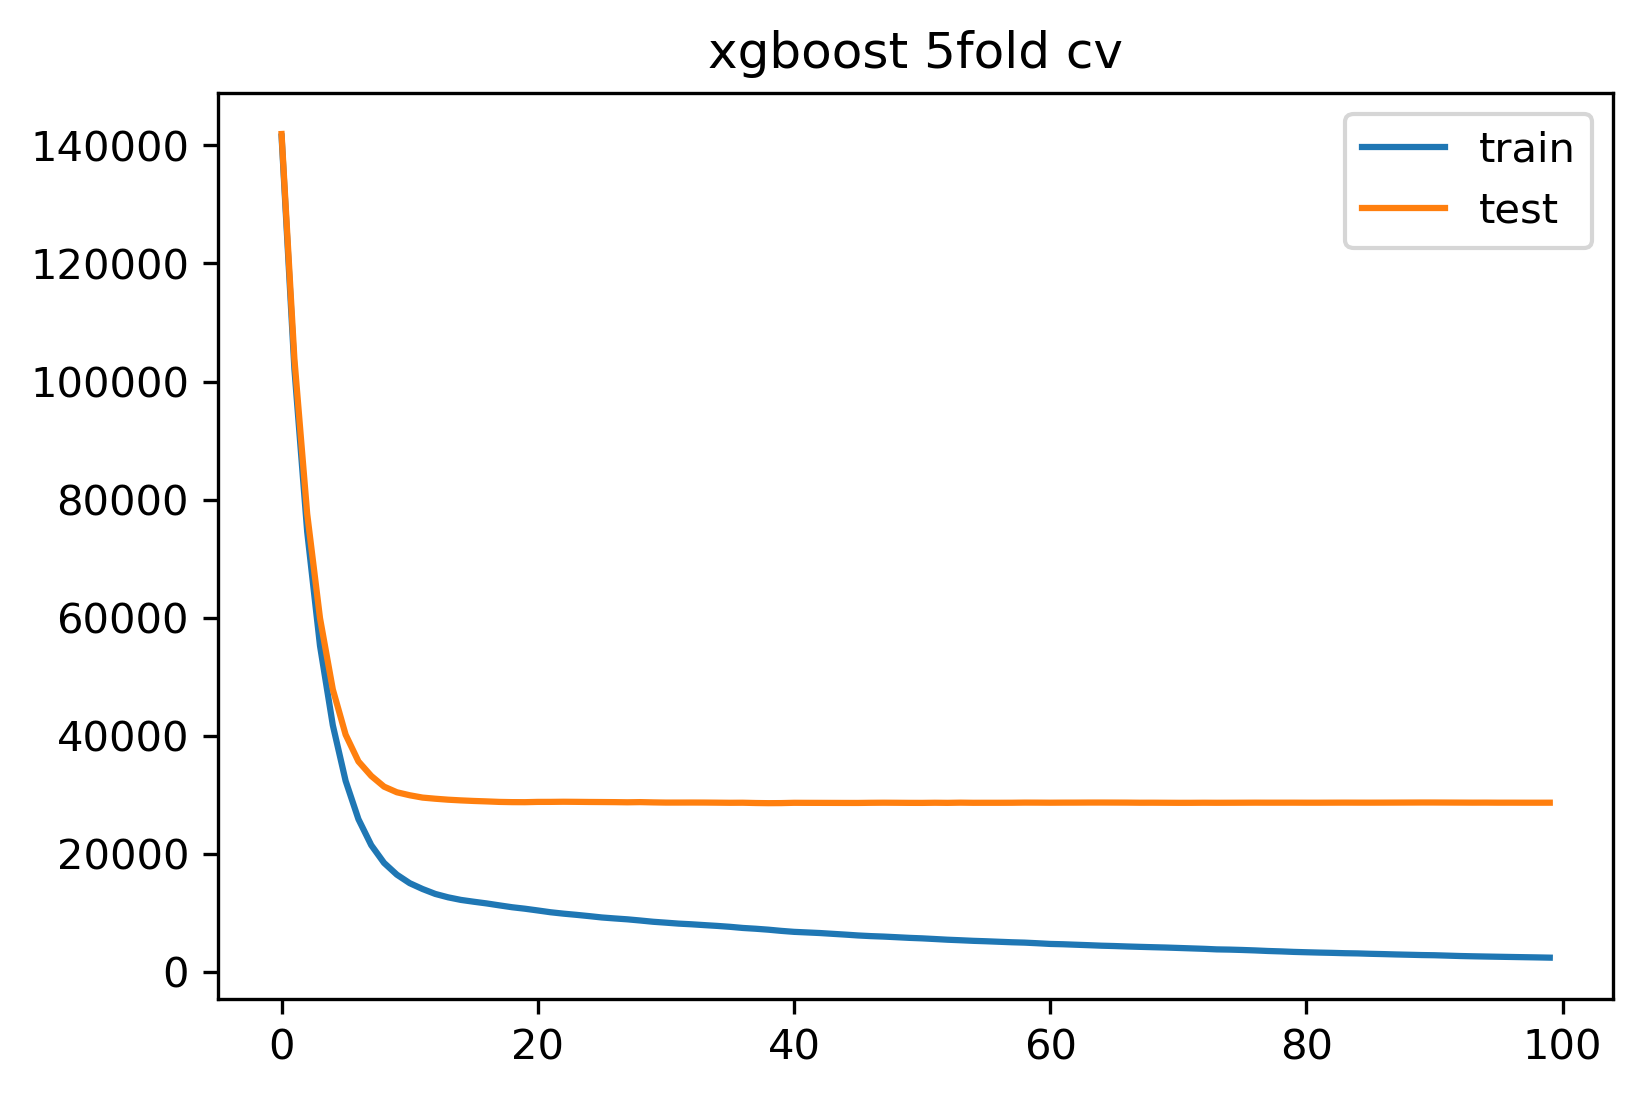

In [68]:
plt.figure(dpi=300)
plt.plot(result["train-rmse-mean"])
plt.plot(result["test-rmse-mean"])
plt.legend(["train","test"])
plt.title("xgboost 5fold cv");

## 4 XGBoost分类的代码实现

# 二 XGBoost的参数

## 1 迭代过程

### 1.1 迭代次数/学习率/初始$H_0$/最大迭代值

### 1.2 xgboost的目标函数

在之前的课程当中，我们已经简单介绍过xgboost常用的几种损失函数。与GBDT一样，xgboost的损失函数理论上可以推广到任意可微函数，因此只要是我们在之前的课程中介绍过的损失函数都可以被用于xgboost。但与GBDT不同的是，xgboost并不向着损失函数最小化的方向运行，而是如我们在前面所提到的，**xgboost向着令目标函数最小化的方向运行**。

需要注意的是，损失函数可以针对单个样本进行计算，也可以针对整个算法进行计算，**但在XGBoost的定义中，目标函数是针对每一棵树的，而不是针对一个样本或整个算法**。对任意树$f_k$来说，目标函数有两个组成部分，一部分是任意可微的损失函数，它控制模型的**经验风险**。从数值上来说，它等于现在树上所有样本上损失函数之和，其中单一样本的损失为$l(y_i,\hat{y_i})$。另一部分是控制模型复杂度的$\Omega(f_k)$，它控制当前树的**结构风险**。<br>

<center>$Obj_k = \sum_{i=1}^Ml(y_i,\hat{y_i}) + \Omega(f_k)$</center><br>

其中$M$表示现在这棵树上一共使用了M个样本，$l$表示单一样本的损失函数。当模型迭代完毕之后，最后一棵树上的目标函数就是整个XGBoost算法的目标函数。

- **经验风险**：模型对数据学习越深入，损失越小（经验风险越小），模型对数据学习得越浅显，损失越大（经验风险越大）。

- **结构风险**：树结构越复杂、模型复杂度越高，过拟合风险越大（结构风险越大）。树模型结构越简单、模型复杂度越低、过拟合风险越小（结构风险越小）。

通常来说，模型需要达到一定的复杂度，才能保证较小的损失，但如果只追求最小的经验风险，反而容易导致过拟合。相对的，如果只追求模型复杂度低、结构风险低，那模型又容易陷入欠拟合的困局、损失函数过高，因此平衡结构风险与经验风险十分关键。XGBoost向着目标函数最小化的方向运行，可以保证在迭代过程中，经验风险和结构风险都不会变得太大，因此模型的损失不会太大、同时又不会太容易过拟合。这一目标函数的设计可谓相当聪明。

In [88]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

在具体的公式当中，结构风险$\Omega(f_k)$又由两部分组成，一部分是控制树结构的$\gamma T$，另一部分则是正则项：

<center>$\Omega(f_k) = \boldsymbol{\color{red}\gamma} T + \frac{1}{2}\boldsymbol{\color{red}\lambda}\sum_{j=1}^Tw_j^2 + \boldsymbol{\color{red}\alpha}\sum_{j=1}^Tw_j$</center><br>

其中$\gamma$，$\lambda$与$\alpha$都是可以自由设置的系数，而$T$表示当前第$k$棵树上的叶子总量，$w_j$则代表当前树上第$j$片叶子的叶子权重（leaf weights）。**叶子权重是XGBoost数学体系中非常关键的一个因子，它实际上就是当前叶子$j$的预测值**，这一指标与数据的标签量纲有较大的关系，因此当标签的绝对值较大、$w_j$值也会倾向于越大。因此正则项有两个：使用平方的L2正则项与使用绝对值的L1正则项，因此完整的目标函数表达式为：

$$Obj_k = \sum_{i=1}^Ml(y_i,\hat{y_i}) + \boldsymbol{\color{red}\gamma} T + \frac{1}{2}\boldsymbol{\color{red}\lambda}\sum_{j=1}^Tw_j^2 + \boldsymbol{\color{red}\alpha}\sum_{j=1}^Tw_j$$

不难发现，所有可以自由设置的系数都与结构风险有关，这三个系数也正对应着xgboost中的三个参数：`gamma`，`alpha`与`lambda`。

- 参数`gamma`：乘在一棵树的叶子总量$T$之前，依照叶子总量对目标函数施加惩罚的系数，默认值为0，可填写任何[0, ∞]之间的数字。当叶子总量固定时，`gamma`越大，结构风险项越大；同时，当`gamma`不变时，叶子总量越多、模型复杂度越大，结构风险项也会越大。在以上两种情况下，目标函数受到的惩罚都会越大，因此**调大`gamma`可以控制过拟合**。<br><br>
- 参数`alpha`与`lambda`：乘在正则项之前，依照叶子权重的大小对目标函数施加惩罚的系数，也就是正则项系数。`lambda`的默认值为1，`alpha`的默认值为0，因此xgboost默认使用L2正则化。通常来说，我们不会同时使用两个正则化，但我们也可以尝试这么做。$\sum_{j=1}^Tw_j$是当前树上所有叶子的输出值之和，因此当树上的叶子越多、模型复杂度越大时，$\sum_{j=1}^Tw_j$自然的数值自然会更大，因此当正则项系数固定时，模型复杂度越高，对整体目标函数的惩罚就越重。当$w$固定时，正则项系数越大，整体目标函数越大，因此**调大`alpha`或`lambda`可以控制过拟合**。

|参数含义|原生代码|sklearn API|
|:-:|:-:|:-:|
|乘在叶子节点数量前的系数|**gamma**<br>(params)|**gamma**|
|L2正则项系数|**lambda**<br>(params)|**reg_lambda**|
|L1正则项系数|**alpha**<br>(params)|**reg_alpha**|

然而，在实际控制过拟合的过程中，大家可能经常会发现这几个参数“无效”。比如我们可以看到：

In [19]:
import xgboost as xgb

data_xgb = xgb.DMatrix(X,y)
params_default = {"max_depth":5,"seed":1412}
result_default = xgb.cv(params_default,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
result_default.iloc[-1,:]

train-rmse-mean     2362.659668
train-rmse-std       218.221383
test-rmse-mean     28623.220313
test-rmse-std       7526.333222
Name: 99, dtype: float64

In [25]:
#定义一个函数，用来检测模型迭代完毕后的过拟合情况
def overfitcheck(result):
    return (result.iloc[-1,2] - result.iloc[-1,0]).min()

In [26]:
overfitcheck(result_default)

26260.560644800004

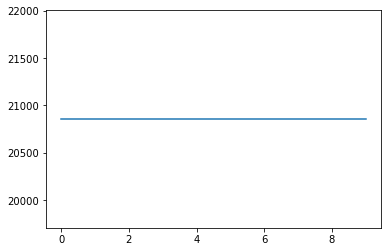

In [28]:
train = []
test = []
gamma = np.arange(0,10,1)
overfit = []
for i in gamma:
    params = {"max_depth":5,"seed":1412,"eta":0.1
              ,"gamma":float(i)
             }
    result = xgb.cv(params,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])
plt.plot(gamma,overfit);

绘制gamma与train的图像再观察：

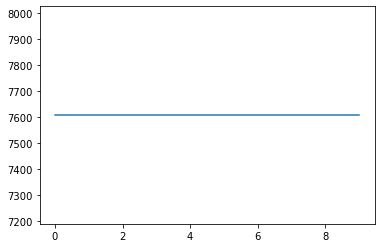

In [29]:
plt.plot(gamma,train);

如上所示，训练集结果纹丝不动，过拟合程度也纹丝不动。这是不是`gamma`失效了呢？实际上，**对于没有上限或下限的参数，我们要关注参数的敏感度。**如果参数值稍稍移动，模型就变化很大，那参数敏感，如果参数值移动很多，模型才能有变化，那参数不敏感。当树的结构相对复杂时，`gamma`会比敏感，否则`gamma`可能非常迟钝。当原始标签数值很大、且叶子数量不多时，`lambda`和`alpha`就会敏感，如果原始标签数值很小，这两个参数就不敏感。因此在使用这些参数之前，最好先对参数的敏感程度有一个探索，这里很容易看到：

- 当前树结构不复杂，`gamma`不敏感

In [30]:
train = []
test = []
gamma = np.arange(0,10000000,1000000)
overfit = []
for i in gamma:
    params = {"max_depth":5,"seed":1412,"eta":0.1
              ,"gamma":float(i)
              #,"lambda":400
             }
    result = xgb.cv(params,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])

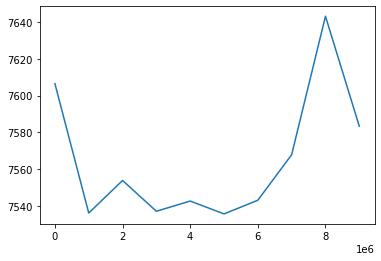

In [31]:
plt.plot(gamma,train);

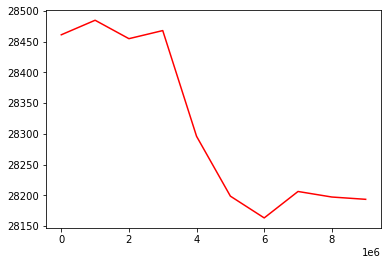

In [32]:
plt.plot(gamma,test,color="red");

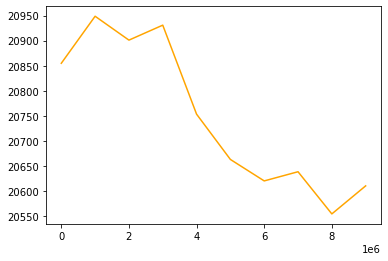

In [33]:
plt.plot(gamma,overfit,color="orange");

`gamma`控制过拟合的最好成绩：

In [35]:
min(overfit)

20554.4015628

- 当前标签值较大，因此预测标签的值也较大，`lambda`会更敏感

In [303]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [36]:
train = []
test = []
lambda_ = np.arange(1,2,0.1)
overfit = []
for i in lambda_:
    params = {"max_depth":5,"seed":1412,"eta":0.1
              ,"lambda":float(i)
             }
    result = xgb.cv(params,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])

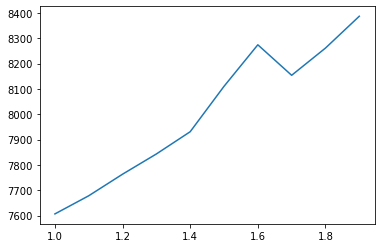

In [37]:
plt.plot(lambda_,train);

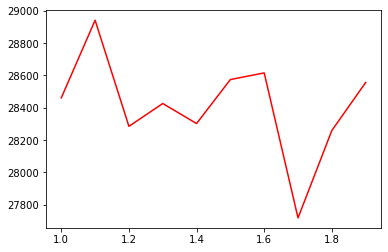

In [38]:
plt.plot(lambda_,test,color="red");

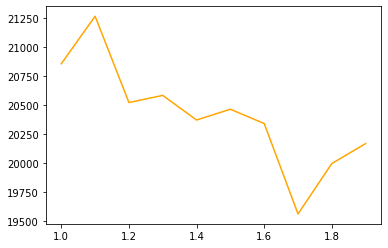

In [41]:
plt.plot(lambda_,overfit,color="orange");

`lambda`控制过拟合的最好成绩：

In [43]:
min(overfit)

19564.888281400003

可见，现在`lambda`比`gamma`有效。当然，在实际使用时，并不是在所有数据情况下都如此，需要根据具体情况具体分析。因此在使用和调节这些参数时，要先考虑适合的参数范围，否则再多的搜索也是无用。总结一下，在整个迭代过程中，我们涉及到了如下参数：

|类型|参数|
|---|---|
|**迭代过程/损失函数**|num_boost_round：集成算法中弱分类器数量，对Boosting算法而言为实际迭代次数<br><br>eta：Boosting算法中的学习率，影响弱分类器结果的加权求和过程<br><br><font color="green">**objective**</font>：选择需要优化的损失函数<br><br><font color="green">**base_score**</font>：初始化预测结果$H_0$的设置<br><br><font color="green">**max_delta_step**</font>：一次迭代中所允许的最大迭代值<br><br><font color="green">**gamma**</font>：乘在叶子数量前的系数，放大可控制过拟合<br><br><font color="green">**lambda**</font>：L2正则项系数，放大可控制过拟合<br><br><font color="green">**alpha**</font>：L1正则项系数，放大可控制过拟合|

## 2 XGBoost的弱评估器

### 2.1 三大评估器与DART树

### 2.2 弱评估器的分枝

当参数`booster`的值被设置为gbtree时，XGBoost所使用的弱评估器是改进后的的CART树，其分枝过程与普通CART树高度一致：向着叶子质量提升/不纯度下降的方向分枝、并且每一层都是二叉树。在CART树的基础上，XGBoost创新了全新的分枝指标：**结构分数（Structure Score）与结构分数增益（Gain of Structure Score）**（也被叫做结构分数之差），更大程度地保证了CART树向减小目标函数的方向增长。需要注意的是，**XGBoost不接受其他指标作为分枝指标**，因此你会发现在众多的xgboost的参数中，并不存在`criterion`参数：

|类型|参数|
|-|-|
|**迭代过程/目标函数**|**params**: eta, base_score, objective, <font color="green">**lambda, gamma, alpha, max_delta_step**</font><br>**xgb.train()**: num_boost_round|
|**弱评估器结构**|**params**: max_depth, <font color="green">**booster, min_child_weight**</font>|
|**dart树**|**params**: <font color="green">**sample_type, normalized_type, rate_drop, one_drop, skip_drop**</font>|
|**弱评估器的训练数据**|**params**: subsample, <font color="green">**sampling_method, colsamle_bytree, colsample_bylevel, colsample_bynode**</font>|
|**提前停止**|**xgb.train()**: <font color="green">**early_stopping_rounds, evals**</font>, eval_metric|
|**其他**|**params**: seed, <font color="green">**verbosity, scale_pos_weight, nthread**</font>|

<br>幸运的是，没有任何参数与结构分数的公式本身相关，因此从应用xgboost的角度来看，我们并不需要对结构分数以及相应的分枝过程理解太深，只需对公式稍作了解即可。不过，结构分数是XGBoost整个运行流程中非常核心的概念，它即精又巧，串起了整个XGBoost几乎所有的数学流程。在原始论文中，作者陈天奇使用了一整节的篇幅来推导结构分数的公式，因此这部分原理非常值得学习。如果你渴望学习相关原理，可以查看数学的最后一节。现在，我们来了解结构分数的相关公式：

**假设现在目标函数使用L2正则化，控制叶子数量的参数`gamma`为0。现在存在一个叶子节点$j$，对该节点来说结构分数的公式为：**

$$ Score_j = \frac{(\sum_{i \in j}g_i)^2}{\sum_{i \in j}h_i + \lambda}$$

其中，$g_i$是样本$i$在损失函数$L$上对预测标签求的一阶导数，$h_i$是样本$i$在损失函数$L$上对预测标签求的二阶导数，$i \in j$表示对叶子$j$上的所有样本进行计算，$\lambda$就是L2正则化的正则化系数。所以不难发现，结构分数实际上就是：

$$Score_j = \frac{节点j上所有样本的一阶导数之和的平方}{节点j上所有样本的二阶导数之和 + \lambda}$$

需要注意结构分数是针对节点计算的，我们以前学习的不纯度衡量指标如基尼系数、信息熵等也是如此。在此基础上，我们依赖于结构分数增益进行分枝，结构分数增益表现为：

$$\begin{align}
Gain &= Score_L + Score_R - Score_P \\ \\
&= \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda}\\ \\
&（见原论文7号公式）
\end{align}$$

这即是说，结构分数增益实际上就是：

$$Gain = 左节点的结构分数 + 右节点的结构分数 - 父节点的结构分数$$

**我们选择增益$Gain$最大的点进行分枝**。

你是否注意到，XGBoost中的分枝规则与经典CART树的分枝规则在细节上有所不同？CART树中所使用的信息增益是：

$$CART树中的信息增益 = 父节点的不纯度 - （左节点的不纯度 + 右节点的不纯度）$$

我们追求的是最大的信息增益，这意味着随着CART树的建立整体不纯度是在逐渐降低的。无论不纯度衡量指标是基尼系数还是信息熵，不纯度是越小越好。然而在XGBoost当中，增益的计算公式与CART树相反，但我们依然追求最大增益，所以这意味着**随着XGBoost树的建立，整体结构分数是逐渐上升的**。因此我们可以认为**结构分数越大越好**。

那结构分数的含义是什么呢？它也像信息熵一样，可以衡量叶子节点的某种属性吗？为什么结构分数需要越大越好呢？这些问题需要大家了解数学推导过程后才能解答，但我们在这里可以举一个很简单的例子来证实结构分数增益越大、选出的分枝越好。

假设现在我们有一个超简单的节点需要分割，该节点中所包含的样本如下：

|样本|y|y_hat|
|:-:|:-:|:-:|
|1|1|0.5|
|2|-2|0.5|
|3|-2|0.5|

**众所周知，在决策树中一个节点只能有一个输出值，因此同一片叶子上所有样本的预测值都一致**，不同的树模型使用不同的方法来计算叶子节点上的输出值，大部分模型都直接使用样本的真实值的均值作为输出，但XGBoost有自己不同的手段。现在我们可以暂时忽略这一点，先假设当前的节点预测值为0.5。

现在要对该节点进行分割，你知道从哪里分枝会最有效吗？因为一片叶子只会输出一个预测值，所以相同标签的样本最好在一片叶子上。因此很明显，因为2、3号叶子的真实值一致，我们应该将该节点从1号样本和2号样本中间分开，让1号样本单独在一片叶子上，而2、3号样本在一片叶子上（1，23）。但实际在进行分枝时，我们需要尝试所有可能的方式，并分别计算以下方式的结构分数增益：

- 分割方案1:（1,23）

|左子节点|y|y_hat||右子节点|y|y_hat|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5||2|-2|0.5|
|||||3|-2|0.5|

- 分割方案2:（12,3）

|左子节点|y|y_hat||右子节点|y|y_hat|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5||3|-2|0.5|
|2|-2|0.5|||||

假设现在执行的是XGBoost回归，损失函数为0.5倍MSE，公式为$\frac{1}{2}(y - \hat{y})^2$，假设lambda=1。那基于MSE的一阶导数为：

$$\begin{align}
l&= \frac{1}{2}(y_i - \hat{y_i})^2 \\ \\ 
l' &= \frac{\partial}{\partial \hat{y_i}} \frac{1}{2}(y_i - \hat{y_i})^2\\ \\
&= - (y_i - \hat{y_i})\\ \\
&= \hat{y_i} - y_i\\ \\
\end{align}$$

基于MSE的二阶导数为：

$$\begin{align}
l'' &= \frac{\partial}{\partial \hat{y_i}} (\hat{y_i} - y_i)\\ \\
&= 1
\end{align}$$

因此无论如何划分，$g_i = \hat{y_i} - y_i$，$h_i = 1$。现在来计算父节点和两个子节点上每个样本的$g_i$与$h_i$：

- 父节点：

|样本|y|y_hat|gi|hi|
|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5|-0.5|1|
|2|-2|0.5|2.5|1|
|3|-2|0.5|2.5|1|

因此父节点的结构分数为：

$$\begin{align}
Score_P &= \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \\ \\
&= \frac{(-0.5 + 2.5 + 2.5)^2}{3 + 1} \\ \\
&= 5.0625
\end{align}$$

- 方案1

|左子节点|y|y_hat|gi|hi||右子节点|y|y_hat|gi|hi|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5|-0.5|1||2|-2|0.5|2.5|1|
|||||||3|-2|0.5|2.5|1|

方案1下两个子节点的结构分数为：

$$\begin{align}
Score_{L1} &= \frac{(\sum_{i \in {L1}}g_i)^2}{\sum_{i \in {L1}}h_i + \lambda} \\ \\
&= \frac{(-0.5)^2}{1 + 1} \\ \\
&= 0.125
\end{align}$$

<br>

$$\begin{align}
Score_{R1} &= \frac{(\sum_{i \in {R1}}g_i)^2}{\sum_{i \in {R1}}h_i + \lambda} \\ \\
&= \frac{(2.5+2.5)^2}{2 + 1} \\ \\
&= 8.333
\end{align}$$

因此增益等于：

$$\begin{align}
Gain &= Score_{L1} + Score_{R1} - Score_P \\ \\
&= 0.125 + 8.333 - 5.6025 \\ \\
&= 3.395
\end{align}$$

- 方案2

|左子节点|y|y_hat|gi|hi||右子节点|y|y_hat|gi|hi|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5|-0.5|1||3|-2|0.5|2.5|1|
|2|-2|0.5|2.5|1|||||||

方案1下两个子节点的结构分数为：

$$\begin{align}
Score_{L1} &= \frac{(\sum_{i \in {L1}}g_i)^2}{\sum_{i \in {L1}}h_i + \lambda} \\ \\
&= \frac{(-0.5 + 2.5)^2}{2 + 1} \\ \\
&= 1.333
\end{align}$$

<br>

$$\begin{align}
Score_{R1} &= \frac{(\sum_{i \in {R1}}g_i)^2}{\sum_{i \in {R1}}h_i + \lambda} \\ \\
&= \frac{(2.5)^2}{1 + 1} \\ \\
&= 3.125
\end{align}$$

因此增益等于：

$$\begin{align}
Gain &= Score_{L1} + Score_{R1} - Score_P \\ \\
&= 1.333 + 3.125 - 5.0625 \\ \\ 
&= -0.604
\end{align}$$

|方案|左侧结构分数|右侧结构分数|父节点结构分数|增益|
|:-:|:-:|:-:|:-:|:-:|
|**(1,23)**|0.125|8.333|5.0625|<font color="green">**3.3958**</font>|
|**(12,3)**|1.333|3.125|5.0625|-0.6041|

很明显，方案1（1,23）的增益为3.395，远远大于方案2（12，3）的增益-0.604，因此根据结构分数增益的指示，我们应该使用第一种分割方式，这与我们经验判断的一致。在XGBoost建树过程中，我们需要对每一个节点进行如上计算，不断来选出令增益更大的分枝。

- 结构分数与信息熵的关键区别

不知道你是否注意到一个问题。在之前我们提到过，结构分数是越大越好。在方案1当中，左侧叶子节点上的结构分数为0.125，右侧叶子节点上的结构分数为8.333，这是否意味着左侧叶子比右侧叶子更好呢？**答案是否定的。与信息熵、基尼系数等可以评价单一节点的指标不同，结构分数只能够评估结构本身的优劣，不能评估节点的优劣**。

比如说，方案1中的树结构有更高的分数之和，方案2中的树结构的分数之和较低，所以方案1更好。但我们不能说，方案1中的左节点分数低，右节点分数高，所以右节点比左节点更好。因此，在XGBoost原始论文当中，**我们利用一棵树上所有叶子的结构分数之和来评估整棵树的结构的优劣**，分数越高则说明树结构质量越高，因此在原论文中，结构分数也被称为质量分数（quality score）。

### 2.3 控制复杂度（一）：弱评估器的剪枝

### 2.4 控制复杂度（二）：弱评估器的训练数据

## 3 XGBoost的其他参数与方法

# 三 XGBoost的参数空间与超参数优化
## 1 确定XGBoost优化的参数空间

## 2 基于TEP对XGBoost进行优化

# 四 原理进阶：XGBoost的求解流程

**<font color="red">学习XGBoost的数学原理需要大量梯度提升树（GBDT）相关知识，本课程将假设你已经非常熟悉梯度提升树的原理与特点。如果你不熟悉梯度提升树，强烈建议你回顾之前的课程。</font>**

## 1 XGBoost的基本数学流程

## 2 化简XGBoost的目标函数

## 3 求解XGBoost的目标函数